<font color="#CA3532" style="font-size:40px"><h1 align="left" >Pruebas con GANs</h1></font>
<font color="#6E6E6E"><h3 align="left">Jaen-Lorites, Jose Manuel</h3></font> 

# Índice:

1. [Cargamos los datos](#load-data)  


In [34]:
import sys; sys.path.insert(0, '../Scripts')
# import load_images
from load_images import load_images, get_df_paths
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from IPython import display
import time

# 1. Cargamos los datos<a class="anchor" id="load-data"></a>

## 2. Definimos el modelo

*https://www.tensorflow.org/tutorials/generative/dcgan*

In [35]:
INPUT_SHAPE_GENERATOR = (100,)
INPUT_SHAPE_DISCRIMINATOR = [180, 180, 1]

EPOCH = 5
BATCH_SIZE = 256  # No es posible mayor número (OOM). Si se modifica la red, seguramente toque reducir este tamaño.
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


### Generador 

In [36]:
generator = tf.keras.Sequential()
generator.add(layers.Dense(5*5*256, use_bias=False, input_shape=INPUT_SHAPE_GENERATOR))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((5, 5, 256)))
assert generator.output_shape == (None, 5, 5, 256)  # Note: None is the batch size

generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator.output_shape == (None, 5, 5, 128)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 10, 10, 64)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 20, 20, 64)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False))
assert generator.output_shape == (None, 60, 60, 64)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(3, 3), padding='same', use_bias=False, activation='sigmoid'))
assert generator.output_shape == (None, 180, 180, 1)


In [56]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6400)              640000    
_________________________________________________________________
batch_normalization_10 (Batc (None, 6400)              25600     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 6400)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 5, 5, 128)         819200    
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 5, 5, 128)        

### Discriminador 

In [37]:
discriminator = tf.keras.Sequential()
discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                 input_shape=INPUT_SHAPE_DISCRIMINATOR))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))


### Funciones de perdida y optimizadores

In [38]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


### Funciones de entrenamiento 

In [39]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


In [40]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for batch, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
#             print(f"\rBatch {batch}: gen_loss is {gen_loss:.4f}; disc_loss is {disc_loss:.4f}", end="" if batch%10!=0 else "\n")
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
    #     if (epoch + 1) % 15 == 0:
    #         checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)


In [41]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [48]:
train_images = load_images(get_df_paths(n=0, random=False))[:, :, :, None]
ds_img = tf.data.Dataset.from_tensor_slices(train_images.astype("float16"))
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255, 
#     featurewise_center=True,  # Hace que la media de todo el dataset sea 0 (no de cada imagen, para ello ver docu)
#     featurewise_std_normalization=True,
    rotation_range=8,
    zoom_range=0.15,
    shear_range=0.05,
#     brightness_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    )
img_gen.fit(train_images, augment=True, seed=666)


In [53]:
train_images.shape

(4357, 180, 180, 1)

In [49]:
generated_dataset = tf.data.Dataset.from_generator(
    lambda: img_gen.flow(train_images, batch_size=BATCH_SIZE).next(), 
    output_types=(tf.float16), 
    output_shapes=([180,180,1]),
    ).take(BATCH_SIZE*5)
train_dataset = ds_img.concatenate(generated_dataset)

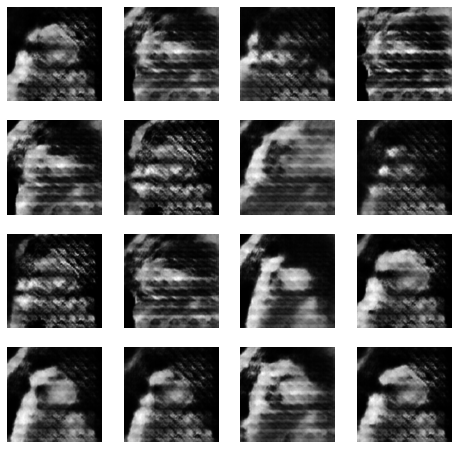

In [52]:
train(train_dataset.batch(BATCH_SIZE), EPOCH*10)

In [32]:
a = train_dataset.as_numpy_iterator().next()
b = train_dataset.as_numpy_iterator().next()

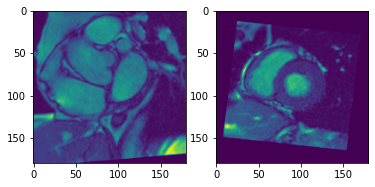

In [33]:
plt.subplot(1,2,1)
plt.imshow(np.rint(a[0,:,:,0]*255).astype("int"))
plt.subplot(1,2,2)
plt.imshow(np.rint(b[0,:,:,0]*255).astype("int"))

In [17]:
a.min()

0.0

In [47]:
train_images.dtype

dtype('float64')

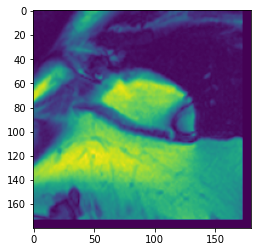

In [55]:
plt.imshow(train_images[20,:,:,0])